To introduce non linearity into the system we use activation functions. for example we use sigmoid, Tanh, ReLU and so on...

Here we will learn to create a simple deep neural network and tune its hyperparameters.


In [1]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

TensorFlow 2.x selected.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [0]:
train_df = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv', sep=',')
train_df = train_df.reindex(np.random.permutation(train_df.index))
test_df = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv', sep=',')

In [6]:
# normalizing the values, by calculating z score

train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean) / train_df_std

test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean) / test_df_std
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14688,-1.3,1.0,1.4,-0.2,-0.4,-0.1,-0.4,-0.9,-1.0
9496,0.1,0.3,0.5,-0.6,-0.4,-0.2,-0.4,-1.3,-1.2
11843,-0.9,1.4,-1.4,-0.4,-0.3,-0.6,-0.2,-0.9,-0.4
3868,0.8,-0.8,0.6,-0.3,-0.5,-0.3,-0.4,0.7,-0.1
3065,0.9,-0.8,-0.7,0.1,-0.5,-0.4,-0.5,4.4,2.5


In [0]:
feature_column = [] # empty list for holding all feature columns.

resolution_in_zs = 0.3

# create bucket feature column for latitude.
latitude_numeric_column = tf.feature_column.numeric_column('latitude')
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), int(max(train_df_norm['latitude'])), resolution_in_zs))
bucket_latitude = tf.feature_column.bucketized_column(latitude_numeric_column, latitude_boundaries)

# create bucket feature column for longitude.
longitude_numeric_column = tf.feature_column.numeric_column('longitude')
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), int(max(train_df_norm['longitude'])), resolution_in_zs))
bucket_longitude = tf.feature_column.bucketized_column(longitude_numeric_column, longitude_boundaries)

# feature cross for longitude and latitude
longi_x_lati = tf.feature_column.crossed_column([bucket_latitude, bucket_longitude], hash_bucket_size=100)
longi_x_lati_col = tf.feature_column.indicator_column(longi_x_lati)
feature_column.append(longi_x_lati_col)

# feature column for median income
median_income = tf.feature_column.numeric_column('median_income')
feature_column.append(median_income)

# feature column for population
population = tf.feature_column.numeric_column('population')
feature_column.append(population)

# convert the list of feature column into a dense layer that will later be fed into network for training.
my_feature_layer = tf.keras.layers.DenseFeatures(feature_column)

In [0]:
# define plotting function
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()

In [0]:
# creating functions to create and train model

def create_model(my_learning_rate, feature_layer):
  '''create and compile a simple linear regression model'''

  model = tf.keras.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(my_learning_rate), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [0]:
def train_model(model, dataset, epochs, batch_size, label_name):

  features = {key:np.array(value) for key, value in dataset.items()}
  label = np.array(features.pop(label_name))

  history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist['mean_squared_error']

  return epochs, rmse

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train on 17000 samples
Epoch 1/15
17000/17000 [==============================] - 1s 40us/sample - loss: 0.6140 - mean_squared_error: 0.6140
Epoch 2/15
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4543 - mean_squared_error: 0.4543
Epoch 3/15
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3999 - mean_squared_error: 0.3999
Epoch 4/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3801 - mean_squared_error: 0.3801
Epoch 5/15
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3698 - mean_squared_error: 0.3698
Epoch 6/15
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3644 - mean_squared_error: 0.3644
Epoch 7/15
17000/17000 [========

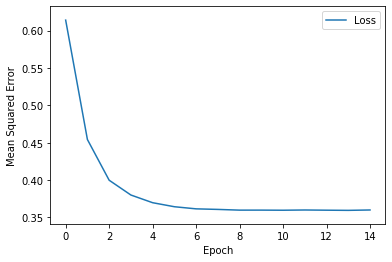


 Evaluate the linear regression model against the test set:
3000/3000 [==============================] - 0s 39us/sample - loss: 0.3951 - mean_squared_error: 0.3951


[0.39514560500780743, 0.3951456]

In [16]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = 'median_house_value'

my_model = create_model(learning_rate, my_feature_layer)

epochs, rmse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

test_feature = {key:np.array(value) for key, value in test_df_norm.items()}
test_label = np.array(test_feature.pop(label_name))

print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x=test_feature, y=test_label, batch_size=batch_size)

In [0]:
def create_deep_model(my_learning_rate, feature_layer):

  model = tf.keras.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(10, 'relu', name='hidden1'))
  model.add(tf.keras.layers.Dense(6, 'relu', name='hidden2'))
  model.add(tf.keras.layers.Dense(1, name='output'))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(my_learning_rate), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [0]:
def train_deep_model(model, dataset, epochs, label_name, batch_size=None):

  features = {key:np.array(value) for key, value in dataset.items()}
  label = np.array(features.pop(label_name))

  history = model.fit(x=features, y = label, epochs = epochs, batch_size=batch_size, shuffle=True)

  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist['mean_squared_error']

  return epochs, mse

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 0s 28us/sample - loss: 0.5567 - mean_squared_error: 0.5567
Epoch 2/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.3581 - mean_squared_error: 0.3581
Epoch 3/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3475 - mean_squared_error: 0.3475
Epoch 4/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3483 - mean_squared_error: 0.3483
Epoch 5/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.3456 - mean_squared_error: 0.3456
Epoch 6/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3433 - mean_squared_error: 0.3433
Epoch 7/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.3439 - mean_squared_error: 0.3439
Epoch 8/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.3429 - mean_squared_error: 0.3429
Epoch 9/20
17000/17000 [========================

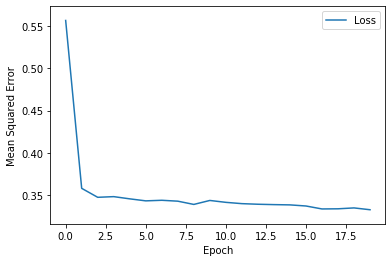

3000/3000 [==============================] - 0s 40us/sample - loss: 0.3800 - mean_squared_error: 0.3800


[0.3800416886806488, 0.38004166]

In [24]:
learning_rate = 0.01
epochs = 20
batch_size = 1000
label_name = 'median_house_value'

my_model = create_deep_model(learning_rate, my_feature_layer)

epochs, mse = train_deep_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

my_model.evaluate(x=test_feature, y=test_label, batch_size=batch_size)

In [0]:
def create_model_dense_regularizatio(my_learning_rate, feature_layer):

  model = tf.keras.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(10, 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='hidden1'))
  model.add(tf.keras.layers.Dense(6, 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='hidden2'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1, name='output'))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(my_learning_rate), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 32us/sample - loss: 0.6016 - mean_squared_error: 0.5314
Epoch 2/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.4498 - mean_squared_error: 0.4032
Epoch 3/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4459 - mean_squared_error: 0.4058
Epoch 4/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.4312 - mean_squared_error: 0.3950
Epoch 5/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.4298 - mean_squared_error: 0.3966
Epoch 6/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.4291 - mean_squared_error: 0.3975
Epoch 7/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.4246 - mean_squared_error: 0.3941
Epoch 8/20
17000/17000 [==============================] - 0s 4us/sample - loss: 0.4309 - mean_squared_error: 0.4012
Epoch 9/20
17000/17000 [========================

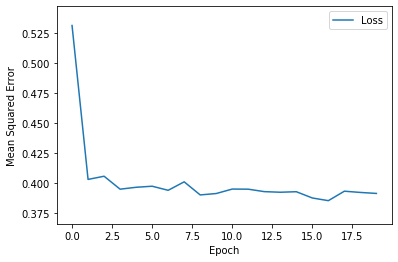

3000/3000 [==============================] - 0s 47us/sample - loss: 0.4046 - mean_squared_error: 0.3818


[0.4046136836210887, 0.38184384]

In [39]:
learning_rate = 0.01
epochs = 20
batch_size = 1000
label_name = 'median_house_value'

my_model = create_model_dense_regularizatio(learning_rate, my_feature_layer)

epochs, mse = train_deep_model(my_model, train_df_norm, epochs, label_name, batch_size)

plot_the_loss_curve(epochs, mse)

my_model.evaluate(x=test_feature, y=test_label, batch_size=batch_size)